In [143]:
#Importing the liberaries
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import pickle
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

# 1. Get Data

In [144]:
input_df = pd.read_excel("feedback.xlsx")

In [145]:
# Remove white spaces from Date fields
input_df.replace('\n','', regex=True, inplace = True)

In [146]:
input_df.head()
# y=feedback_df.Tags

,S.No.,Date,Comment,Tags
0,1,‎01‎ ‎Apr‎ ‎2017,What a complete and utter shambles. My wife ra...,#Loan#Refund#Overpayment
1,2,‎01‎ ‎Apr‎ ‎2017,Another absolutely feckless conversation with ...,#Loan#Payments#SLC
2,3,‎15‎ ‎May‎ ‎2017,Paid off student loan 6 years ago - then sudde...,#Loan#StudentLoan
3,4,‎24‎ ‎Sep‎ ‎2018,"If I could ""leave no star"" - as a previous rev...",#SLC#Loan#customer
4,5,‎17‎ ‎Sep‎ ‎2018,If there were no star they would deserve it. I...,#MaintenanceLoan#Loan#HMRC


# Sentimental Analysis

In [148]:
feedback_df1 = input_df.drop('S.No.', axis=1)

In [149]:
# No. of rows and columns
feedback_df1.shape
# Size of the dataset is small for building the model
feedback_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 3 columns):
Date       43 non-null object
Comment    96 non-null object
Tags       95 non-null object
dtypes: object(3)
memory usage: 2.3+ KB


In [150]:
comment_df = feedback_df1['Comment']
comment_list = comment_df.tolist()
print(len(comment_list))

96


In [152]:
# import nltk
# nltk.download_gui()
# (or)
# Download from anaconda prompt - python -m nltk.downloader brown and python -m nltk.downloader abc

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [170]:
pre_processed_text_new = []
for text in comment_list:
    score = analyser.polarity_scores(text)
#     print("{}".format(str(score)))
    pre_processed_text_new.append(score)
pre_processed_text_df = pd.DataFrame(pre_processed_text_new)
sentiment_df = pd.concat([comment_df, pre_processed_text_df],axis=1)
sentiment_df.head()

,Comment,compound,neg,neu,pos
0,What a complete and utter shambles. My wife ra...,0.3987,0.000,0.974,0.026
1,Another absolutely feckless conversation with ...,-0.8743,0.103,0.897,0.000
2,Paid off student loan 6 years ago - then sudde...,-0.3753,0.051,0.926,0.023
3,"If I could ""leave no star"" - as a previous rev...",-0.8121,0.096,0.850,0.054
4,If there were no star they would deserve it. I...,-0.8930,0.084,0.886,0.030


<Figure size 576x432 with 0 Axes>

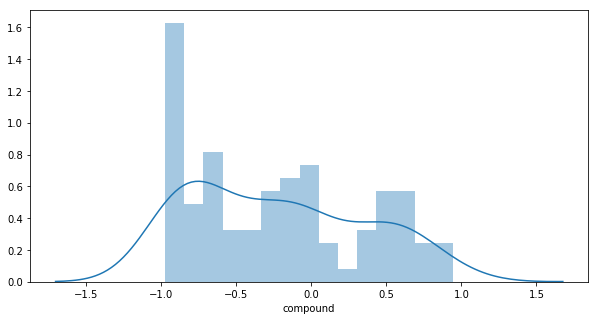

In [177]:
import seaborn as sns
plt.figure(figsize=(8,6))
term_freq_df2 = sentiment_df[['neg','pos','neu','compound']]
# ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
# plt.ylabel('Positive Frequency')
# plt.xlabel('Negative Frequency')
# plt.title('Negative Frequency vs Positive Frequency')

fig = plt.figure(figsize=(10,5))
sns.distplot(term_freq_df2['compound'], bins=15)
plt.show()


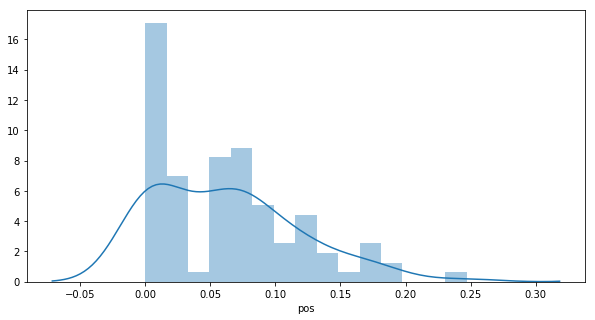

In [178]:
fig = plt.figure(figsize=(10,5))
sns.distplot(term_freq_df2['pos'], bins=15)
plt.show()

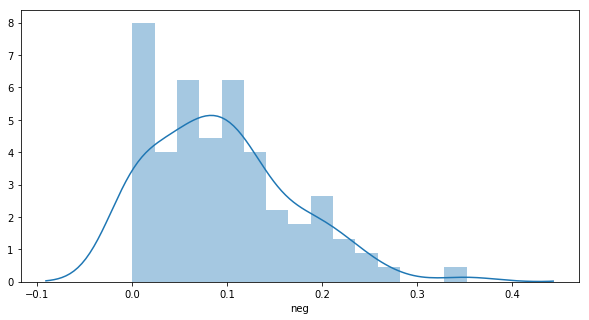

In [179]:
fig = plt.figure(figsize=(10,5))
sns.distplot(term_freq_df2['neg'], bins=15)
plt.show()

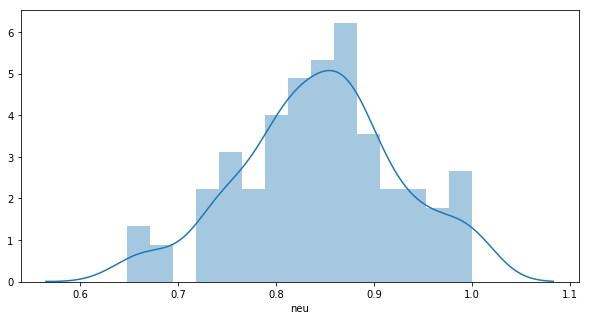

In [180]:
fig = plt.figure(figsize=(10,5))
sns.distplot(term_freq_df2['neu'], bins=15)
plt.show()

# Text Classification

In [130]:
# split the dataset into training and validation datasets 
trainDF = pd.DataFrame()
trainDF['text'] = input_df['Comment']
trainDF['label'] = input_df['Tags']
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])
feedback_df = pd.DataFrame()
feedback_df['Comment'] = train_x
feedback_df['Tags'] = train_y
feedback_df = feedback_df.reset_index(drop=True)
feedback_df.head()

,Comment,Tags
0,What a complete and utter shambles. My wife ra...,#Loan#Refund#Overpayment
1,Can you please confirm what funds exactly you ...,#Overseas#Payment
2,"Your online system doesn't work, and you're un...",#Overseas#Repayment#Communication
3,"The deal was, 'you don't have to pay back any ...",#Overseas#Repayment
4,Why is your website impossible to login to? It...,#website


# 2. Clean Data

With text data, this cleaning process can go on forever. There's always an exception to every cleaning step. So, we're going to follow the MVP (minimum viable product) approach - start simple and iterate. Here are a bunch of things you can do to clean your data. We're going to execute just the common cleaning steps here and the rest can be done at a later point to improve our results.

**Common data cleaning steps on all text:**
* Make text all lower case
* Remove punctuation
* Remove numerical values
* Remove common non-sensical text (/n)
* Tokenize text
* Remove stop words

**More data cleaning steps after tokenization:**
* Stemming / lemmatization
* Parts of speech tagging
* Create bi-grams or tri-grams
* Deal with typos
* And more...


In [26]:
# Apply a first round of text cleaning techniques

import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [27]:
data_clean_r1 = pd.DataFrame(feedback_df['Comment'].apply(round1))

In [30]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [31]:
data_clean_r2 = pd.DataFrame(data_clean_r1['Comment'].apply(round2))

In [ ]:
# data_clean_r['Tags'] = feedback_df['Tags']
data_clean_r2
data_clean_r2.to_pickle("data_clean_r2.pkl")

In [39]:
### Document-Term Matrix

# For many of the techniques we'll be using in future notebooks, the text must be tokenized, meaning broken down into smaller pieces. The most common tokenization technique is to break down text into words. We can do this using scikit-learn's CountVectorizer, where every row will represent a different document and every column will represent a different word.
# In addition, with CountVectorizer, we can remove stop words. Stop words are common words that add no additional meaning to text such as 'a', 'the', etc.

In [45]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv_r = cv.fit_transform(data_clean_r2.Comment)
data_dtm_r = pd.DataFrame(data_cv_r.toarray(), columns=cv.get_feature_names())
data_dtm_r.index = data_clean_r.index
data_dtm_r.head()

,abhorrent,ability,able,abroad,absolute,absolutely,abysmal,accents,accept,accepted,...,years,yearspity,yearsshe,youdont,youll,youn,young,youre,youve,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# Exclude most common occuring words

In [69]:
from collections import Counter

c = Counter(**dict(data_dtm_r.sum(axis=0)))
# get the 50 most common elements
# c.most_common(50)
stop_words = [word for word, count in c.most_common() if count > 6]
stop_words

['slc',
 'loan',
 'money',
 'email',
 'pay',
 'phone',
 'just',
 'address',
 'company',
 'year',
 'contact',
 'payments',
 'student',
 'letters',
 'like',
 'send',
 'overseas',
 'people',
 'time',
 'account',
 'letter',
 'live',
 'paid',
 'dont',
 'im',
 'payment',
 'told',
 'website',
 'make',
 'rate',
 'service',
 'trying',
 'uk',
 'want',
 'details',
 'date',
 'sending',
 'sent',
 'staff',
 'called',
 'customer',
 'evidence',
 'number',
 'received',
 'terrible',
 'years',
 'asked',
 'balance',
 'completely',
 'did',
 'emails',
 'exchange',
 'hold',
 'hours',
 'monthly',
 'online',
 'paying',
 'provide',
 'repayments',
 'said',
 'use',
 'absolute',
 'days',
 'doesnt',
 'end',
 'fees',
 'financial',
 'got',
 'information',
 'ive',
 'know',
 'loans',
 'need',
 'organisation',
 'place',
 'response',
 'saying',
 'stop',
 'times',
 'touch',
 'try',
 'unable',
 'updated']

In [70]:
list_exclude_words = ['slc','loan','pay','company','money','payments','student','letters','overseas','account','service','fees','financial','loans','organisation','letter','payment','evidence','customer','balance','paying',
'repayments','exchange','online','information','uk']

add_stop_words = [word for word in stop_words if word not in list_exclude_words]
add_stop_words

['email',
 'phone',
 'just',
 'address',
 'year',
 'contact',
 'like',
 'send',
 'people',
 'time',
 'live',
 'paid',
 'dont',
 'im',
 'told',
 'website',
 'make',
 'rate',
 'trying',
 'want',
 'details',
 'date',
 'sending',
 'sent',
 'staff',
 'called',
 'number',
 'received',
 'terrible',
 'years',
 'asked',
 'completely',
 'did',
 'emails',
 'hold',
 'hours',
 'monthly',
 'provide',
 'said',
 'use',
 'absolute',
 'days',
 'doesnt',
 'end',
 'got',
 'ive',
 'know',
 'need',
 'place',
 'response',
 'saying',
 'stop',
 'times',
 'touch',
 'try',
 'unable',
 'updated']

In [76]:
# Let's update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv_r2 = cv.fit_transform(data_clean_r2.Comment)
data_stop_r2 = pd.DataFrame(data_cv_r2.toarray(), columns=cv.get_feature_names())
# data_stop_r2.index = data_clean_r1.index
data_stop_r2.head()

# Pickle it for later use
import pickle
pickle.dump(cv, open("cv_stop.pkl", "wb"))

# Topic Modeling - Using  Latent Dirichlet Allocation (LDA) with gensim

In [78]:
# LDA was specifically designed for text data.
# To use a topic modeling technique, you need to provide (1) a document-term matrix and (2) the number of topics you would like the algorithm to pick up.

# Once the topic modeling technique is applied, manually the results requires to be interpreted and see if the mix of words in each topic make sense. 
# If they don't make sense, you can try changing up the number of topics, the terms in the document-term matrix, model parameters, or even try a different model.

In [79]:
from gensim import matutils, models
import scipy.sparse

# Prepare term-document matrix
tdm = data_stop_r2.transpose()
tdm.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
abhorrent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ability,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abroad,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
absolutely,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# Convert the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [81]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
cv = pickle.load(open("cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [82]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term), we need to specify two other parameters - the number of topics and the number of passes. 
# Let's start the number of topics at 2, see if the results make sense, and increase the number from there.

In [136]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes
# LDA for num_topics = 2
lda_2 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda_2.print_topics()

[(0,
  '0.012*"slc" + 0.012*"money" + 0.009*"loan" + 0.008*"company" + 0.006*"student" + 0.006*"overseas" + 0.005*"account" + 0.005*"exchange" + 0.005*"pay" + 0.004*"payments"'),
 (1,
  '0.011*"loan" + 0.010*"pay" + 0.009*"letters" + 0.009*"slc" + 0.007*"money" + 0.007*"payments" + 0.005*"letter" + 0.005*"student" + 0.005*"evidence" + 0.004*"payment"')]

In [137]:
# LDA for num_topics = 3
lda_3 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda_3.print_topics()

[(0,
  '0.015*"money" + 0.014*"slc" + 0.011*"loan" + 0.007*"payments" + 0.007*"letters" + 0.007*"evidence" + 0.006*"account" + 0.006*"pay" + 0.005*"student" + 0.005*"company"'),
 (1,
  '0.010*"pay" + 0.008*"slc" + 0.008*"exchange" + 0.007*"uk" + 0.007*"loan" + 0.006*"payments" + 0.006*"overseas" + 0.006*"service" + 0.006*"money" + 0.006*"company"'),
 (2,
  '0.011*"loan" + 0.008*"company" + 0.008*"letter" + 0.008*"slc" + 0.008*"pay" + 0.007*"student" + 0.005*"letters" + 0.005*"service" + 0.005*"overseas" + 0.004*"payment"')]

In [135]:
# LDA for num_topics = 4
lda_4 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda_4.print_topics()

[(0,
  '0.011*"exchange" + 0.009*"slc" + 0.008*"overseas" + 0.007*"student" + 0.007*"money" + 0.007*"outside" + 0.006*"answer" + 0.006*"service" + 0.006*"help" + 0.006*"line"'),
 (1,
  '0.020*"loan" + 0.018*"money" + 0.011*"payments" + 0.011*"slc" + 0.008*"pay" + 0.007*"balance" + 0.005*"account" + 0.005*"financial" + 0.005*"letter" + 0.005*"given"'),
 (2,
  '0.012*"pay" + 0.011*"company" + 0.010*"slc" + 0.009*"account" + 0.008*"loan" + 0.008*"letters" + 0.006*"student" + 0.006*"overseas" + 0.005*"payments" + 0.005*"doing"'),
 (3,
  '0.011*"slc" + 0.009*"company" + 0.007*"pay" + 0.006*"customer" + 0.006*"payment" + 0.005*"letters" + 0.005*"letter" + 0.005*"loan" + 0.005*"service" + 0.005*"money"')]

# Topic Modeling - Nouns Only

One popular trick is to look only at terms that are from one part of speech (only nouns, only adjectives, etc.). Check out the UPenn tag set: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html.

In [88]:
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [101]:
# Apply the nouns function to filter only on nouns
data_nouns_r2 = pd.DataFrame(data_clean_r2.Comment.apply(nouns))
# data_nouns_r2

In [95]:
# Add new stop words
add_stop_words = ["just","told",'like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people','youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said',]
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cvn = CountVectorizer(stop_words=stop_words)
data_cvn_r3 = cvn.fit_transform(data_nouns_r2.Comment)
# data_cvn_r
data_dtmn_r3 = pd.DataFrame(data_cvn_r3.toarray(), columns=cvn.get_feature_names())
data_dtmn_r3.index = data_clean_r.Tags
# data_dtmn_r3.head()

,ability,absolute,accents,access,account,accounts,acknowledgement,action,addition,address,...,words,work,workno,world,year,years,yearspity,yearsshe,youn,youve
Tags,,,,,,,,,,,,,,,,,,,,,
#Loan#Refund#Overpayment,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#Loan#Payments#SLC,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
#Loan#StudentLoan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
#SLC#Loan#customer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#MaintenanceLoan#Loan#HMRC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn_r3.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [97]:
# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.022*"address" + 0.018*"email" + 0.016*"loan" + 0.015*"slc" + 0.014*"student" + 0.013*"letters" + 0.012*"phone" + 0.011*"payment" + 0.010*"company" + 0.010*"evidence"'),
 (1,
  '0.024*"money" + 0.020*"loan" + 0.018*"year" + 0.017*"slc" + 0.016*"phone" + 0.015*"account" + 0.013*"payments" + 0.012*"company" + 0.012*"rate" + 0.011*"service"')]

In [98]:
# Let's try topics = 3
ldan = models.LdaModel(corpus=corpusn, num_topics=3, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.025*"address" + 0.025*"email" + 0.025*"loan" + 0.024*"phone" + 0.022*"slc" + 0.018*"money" + 0.016*"rate" + 0.014*"letter" + 0.013*"payment" + 0.012*"letters"'),
 (1,
  '0.025*"money" + 0.021*"payments" + 0.017*"slc" + 0.015*"service" + 0.015*"account" + 0.013*"year" + 0.013*"student" + 0.010*"customer" + 0.010*"website" + 0.009*"payment"'),
 (2,
  '0.023*"company" + 0.017*"loan" + 0.015*"details" + 0.013*"year" + 0.011*"letters" + 0.010*"date" + 0.009*"organisation" + 0.008*"issue" + 0.008*"minutes" + 0.008*"tax"')]

In [99]:
# Let's try 4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.025*"phone" + 0.023*"address" + 0.019*"student" + 0.018*"payment" + 0.018*"email" + 0.010*"payments" + 0.010*"slc" + 0.010*"company" + 0.010*"evidence" + 0.008*"loans"'),
 (1,
  '0.032*"year" + 0.027*"loan" + 0.026*"payments" + 0.023*"money" + 0.019*"slc" + 0.015*"company" + 0.014*"account" + 0.011*"tax" + 0.011*"letter" + 0.009*"information"'),
 (2,
  '0.025*"letters" + 0.021*"email" + 0.020*"address" + 0.016*"details" + 0.016*"slc" + 0.016*"loan" + 0.012*"touch" + 0.010*"money" + 0.010*"year" + 0.010*"letter"'),
 (3,
  '0.023*"money" + 0.022*"loan" + 0.021*"rate" + 0.018*"slc" + 0.017*"phone" + 0.016*"exchange" + 0.015*"company" + 0.014*"date" + 0.012*"student" + 0.010*"service"')]

# Topic Modeling - Nouns and Adjectives

In [100]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [102]:
# Apply the nouns function to filter only on nouns
data_nouns_adj_r2 = pd.DataFrame(data_clean_r2.Comment.apply(nouns_adj))
# data_nouns_r2

In [109]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj_r2.Comment)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_clean_r.Tags
data_dtmna.head()

,abhorrent,ability,able,absolute,abysmal,accents,access,account,accountable,accounts,...,wrong,year,years,yearspity,yearsshe,youdont,youll,youn,young,youve
Tags,,,,,,,,,,,,,,,,,,,,,
#Loan#Refund#Overpayment,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
#Loan#Payments#SLC,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
#Loan#StudentLoan,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
#SLC#Loan#customer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#MaintenanceLoan#Loan#HMRC,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [111]:
# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.016*"loan" + 0.016*"year" + 0.013*"company" + 0.011*"email" + 0.010*"slc" + 0.010*"phone" + 0.008*"uk" + 0.008*"details" + 0.007*"student" + 0.007*"evidence"'),
 (1,
  '0.021*"money" + 0.016*"slc" + 0.015*"address" + 0.012*"payments" + 0.012*"phone" + 0.011*"loan" + 0.011*"email" + 0.010*"letters" + 0.009*"website" + 0.008*"payment"')]

In [112]:
# Let's try 3 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.017*"loan" + 0.015*"slc" + 0.014*"letters" + 0.012*"student" + 0.011*"year" + 0.009*"address" + 0.009*"uk" + 0.009*"email" + 0.008*"company" + 0.007*"overseas"'),
 (1,
  '0.020*"money" + 0.019*"email" + 0.015*"payments" + 0.013*"address" + 0.013*"slc" + 0.012*"loan" + 0.011*"letter" + 0.011*"phone" + 0.011*"year" + 0.009*"company"'),
 (2,
  '0.017*"phone" + 0.015*"website" + 0.013*"rate" + 0.013*"exchange" + 0.012*"payment" + 0.012*"money" + 0.012*"loan" + 0.011*"slc" + 0.009*"details" + 0.009*"company"')]

In [113]:
# Let's try 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.020*"loan" + 0.012*"letter" + 0.012*"date" + 0.010*"information" + 0.010*"hmrc" + 0.009*"letters" + 0.009*"address" + 0.008*"tax" + 0.008*"organisation" + 0.008*"slc"'),
 (1,
  '0.016*"money" + 0.014*"uk" + 0.013*"details" + 0.013*"slc" + 0.011*"company" + 0.011*"year" + 0.011*"account" + 0.008*"phone" + 0.008*"letters" + 0.008*"payments"'),
 (2,
  '0.017*"slc" + 0.016*"loan" + 0.015*"student" + 0.012*"payment" + 0.010*"year" + 0.010*"company" + 0.010*"email" + 0.010*"experience" + 0.009*"money" + 0.009*"number"'),
 (3,
  '0.019*"email" + 0.019*"address" + 0.019*"phone" + 0.019*"money" + 0.016*"rate" + 0.016*"loan" + 0.014*"slc" + 0.012*"payments" + 0.010*"exchange" + 0.010*"letter"')]

In [ ]:
# Out of the 3 topic models analysed above, the nouns and adjectives, 2 topic one with LDA seems to classify. So let's pull that down here and run it through some more iterations to get more fine-tuned topics.

In [114]:
# Our final LDA model (for now)
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=80)
ldana.print_topics()

[(0,
  '0.018*"money" + 0.017*"payments" + 0.016*"slc" + 0.012*"loan" + 0.011*"year" + 0.010*"account" + 0.009*"student" + 0.009*"phone" + 0.009*"payment" + 0.008*"company"'),
 (1,
  '0.019*"email" + 0.015*"address" + 0.015*"loan" + 0.012*"phone" + 0.011*"slc" + 0.010*"rate" + 0.010*"letters" + 0.009*"company" + 0.008*"money" + 0.008*"letter"')]

# Model Building : 

In [142]:
def train_model(classifier, train_X_obj, train_Y, test_X_obj, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(train_X_obj, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(train_Y)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
        
    return metrics.accuracy_score(predictions, test_X_obj)

In [ ]:
# Model Building - LDA

In [140]:
# X_topics = lda_2.fit_transform(train_y)
# valid_y

In [ ]:
# Model Building - 

In [37]:
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stop = stopwords.words('english')
# data_clean_r2 = pd.DataFrame(data_clean_r['Comment'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)))
# data_clean_r2['Tags'] = data_clean_r['Tags']
# data_clean_r2['Comment']
# freq = pd.Series(' '.join(data_clean_r2['Comment']).split()).value_counts()[:10]
# freq
# freq1 = pd.Series(' '.join(data_clean_r2['Comment']).split()).value_counts()[-20:]
# freq1
# freq1 = list(freq1.index)
# data_clean_r3 = pd.DataFrame(data_clean_r2['Comment'].apply(lambda x: " ".join(x for x in x.split() if x not in freq1)))
# # data_clean_r3['Comment'].head()
# data_clean_r3['Tags'] = data_clean_r['Tags']
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
# X = vectorizer.fit_transform(data_clean).toarray()
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidfconverter = TfidfVectorizer(stop_words=stopwords.words('english'))
# data_clean = tfidfconverter.fit_transform(data_clean).toarray()
# data_clean
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(stop_words='english')
# data_cv_r = cv.fit_transform(data_clean_r.Comment)
# data_dtm_r = pd.DataFrame(data_cv_r.toarray(), columns=cv.get_feature_names())
# data_dtm_r.index = data_clean_r.Tags
# data_dtm_r.to_pickle("dtm_r.pkl")
# data_clean_r.to_pickle('data_clean_r.pkl')
# pickle.dump(cv, open("cv.pkl", "wb"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mourouguessaner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [117]:
# data_dtm
# import pandas as pd

# data = pd.read_pickle('dtm_r.pkl')
# data = data.transpose()
# data.tail(10).T
# data.columns

In [105]:
# top_dict = {}
# for c in data.columns:
#       top = data[c]
        
#     top = data[c].sort_values(ascending=False).head(30)
#     top_dict[c]= list(zip(top.index, top.values))

# top_dict

In [178]:
# from sklearn.feature_extraction import text 
# from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
# data_clean_r = pd.read_pickle('data_clean_r.pkl')

# Add new stop words
# add_stop_words = ["slc","student","money","pay","email","phone","just","year","letter","paid","address","told"]
# stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
# cv = CountVectorizer(stop_words=stop_words)
# data_cv_r = cv.fit_transform(data_clean_r.Comment)
# data_stop_r = pd.DataFrame(data_cv_r.toarray(), columns=cv.get_feature_names())
# data_stop_r.index = data_clean_r.Tags

# Pickle it for later use
# import pickle
# pickle.dump(cv, open("cv_stop_r.pkl", "wb"))
# data_stop_r.to_pickle("dtm_stop_r.pkl")

In [84]:
# data_stop_r
# from gensim import matutils, models
# import scipy.sparse
# tdm_r = data_stop_r.transpose()
# tdm_r.head()

In [156]:
# sparse_counts = scipy.sparse.csr_matrix(tdm_r)
# corpus = matutils.Sparse2Corpus(sparse_counts)
# id2word = dict((v, k) for k, v in cv.vocabulary_.items())
# lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, passes=10)
# lda.print_topics()

In [222]:
# from sklearn.feature_extraction import text 
# from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
# data_clean_r = pd.read_pickle('data_clean_r.pkl')
# data_clean_r

# data_nouns_r = pd.DataFrame(data_clean_r.Comment.apply(nouns))
# data_clean_r.Tags
# data_nouns_r

In [223]:
# Add new stop words
# add_stop_words = ["student","money","pay","email","phone","just","year","letter","paid","address","told",'like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
#                   'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said','uk','contact']
# stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
# cvn = CountVectorizer(stop_words=stop_words)
# data_cvn_r = cvn.fit_transform(data_nouns_r.Comment)
# data_cvn_r
# data_dtmn_r = pd.DataFrame(data_cvn_r.toarray(), columns=cvn.get_feature_names())
# data_dtmn_r.index = data_clean_r.Tags
# data_dtmn_r


In [224]:
# Create the gensim corpus
# corpusn_r = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn_r.transpose()))

# Create the vocabulary dictionary
# id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [131]:
# lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=6, passes=10)
# lda.print_topics()

In [132]:
# corpus_transformed = lda[corpus]
# list(zip([a for [(a,b)] in corpus_transformed], data_dtmna_r.index))

In [2]:
# from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn import decomposition, ensemble

# import pandas, xgboost, numpy, textblob, string
# from keras.preprocessing import text, sequence
# from keras import layers, models, optimizers

In [18]:
# trainDF = pd.read_excel("feedback.xlsx")
# trainDF.replace('\n','', regex=True, inplace = True)
# trainDF['Tags'].replace(np.NaN, '#slc', inplace = True)

In [19]:
# train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['Comment'], trainDF['Tags'])

In [133]:
# label encode the target variable 
# encoder = preprocessing.LabelEncoder()
# train_y = encoder.fit_transform(train_y)
# valid_y = encoder.fit_transform(valid_y)
# valid_y

In [134]:
# word level tf-idf
# tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
# tfidf_vect.fit(trainDF['Comment'])
# xtrain_tfidf =  tfidf_vect.transform(train_x)
# xvalid_tfidf =  tfidf_vect.transform(valid_x)